In [28]:
import requests
import pandas as pd
import torch
from bs4 import BeautifulSoup
from tqdm import tqdm  # Import tqdm for the progress bar
from transformers import AutoTokenizer,AutoModelForSequenceClassification
import seaborn as sns

import re

In [14]:

#pages = [20, 30, 40, 50, 60, 70, 80]
pages = list(range(20, 400, 10))
reviews = []

for page in pages:
    # Construct the URL with the 'start' parameter
    url = f'https://www.yelp.com/biz/fogo-de-chão-brazilian-steakhouse-san-diego-3?start={page}'

    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    regex = re.compile('.*comment.*')
    results = soup.find_all('p', {'class': regex})

    # Append reviews from the current page to the 'reviews' list
    reviews.extend([result.text for result in results])

# 'reviews' now contains reviews from multiple pages
print(len(reviews), 'reviews scraped in total.')


545 reviews scraped in total.


In [17]:
# Instantiate the Model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [21]:
# load reviews into dataframe and score it
df = pd.DataFrame(reviews, columns=['review'])

def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [23]:
df['sentiment'] = df['review'].apply( lambda x: sentiment_score(x[:512]))

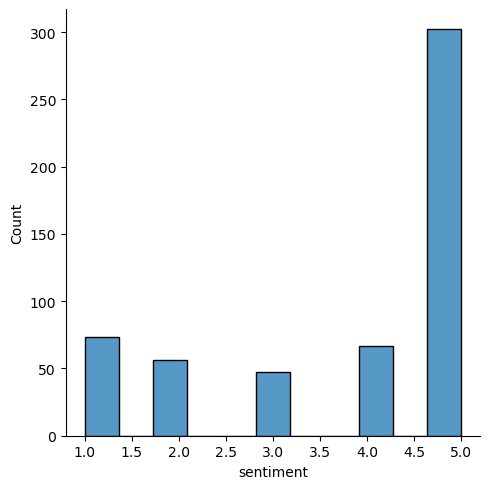

In [29]:
sns.displot(df['sentiment'])

In [25]:
df.head()

,review,sentiment
0,So we came downtown today to see a Filipino ar...,4
1,I had always heard of Fogo Dr Chão so I decide...,4
2,Fogo is a treat every few years. It's not wher...,4
3,Been coming to forgo de chao since they opened...,5
4,Always a great experience here every time I go...,5
